# Assignment 1

In this assignment you will offline analyse the [BCI Competition III dataset II](http://www.bbci.de/competition/iii/#data_set_ii) from the Wadsworth Center in New York made available by Wolpaw, Schalk, and Krusienski. This dataset contains EEG data recorded while two participants operated a standard rows/columns $6 \times 6$ P300 matrix speller. The data of participant 1 is processed and made available on Brightspace. 


### Learning goals
After this assignment, you will have hand-on experience with 
* the BCI cycle as applied to the classic rows/columns P300 speller
* applying a low-pass and high-pass filter and downsampling for preprocessing
* using block-processing to work with epoched data
* spatial filtering using CCA

### Table of contents

1. [The dataset](#dataset)
    1. [The stimulus paradigm](#stimulus)
    2. [The EEG data](#eeg)
2. [Preprocessing](#preproc)
    1. [Spectral filter](#spectralfilter)
    2. [Downsampling](#downsampling)
    3. [Trick for offline analysis](#trick)
3. [Data slicing](#slicing)
    1. [Slicing to epochs](#epochs)
    2. [Temporal response](#temporal)
    3. [Spatial response](#spatial)
4. [Decoding the neural code](#decoding)
    1. [Classifier calibration](#calibration)
    2. [Epoch prediction](#ep)
    3. [Epoch classification](#ec)
    4. [Trial prediction](#tp)
    5. [Trial classification](#tc)
    6. [Decoding curves](#dc)
    7. [Inspecting the classifier](#classifier)
5. [Extension: Canonical Correlation Analysis](#extension)
    1. [The CCA](#cca)
    2. [Classifier calibration](#calibration2)
    2. [Epoch prediction](#ep2)
    3. [Epoch classification](#ec2)
    4. [Trial prediction](#tp2)
    5. [Trial classification](#tc2)
    6. [Decoding curves](#dc2)
    7. [Inspecting the classifier](#classifier2)
 

In [23]:
# Some imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Polygon
from scipy.interpolate import griddata
from scipy.signal import periodogram, butter, filtfilt, decimate
from sklearn.cross_decomposition import CCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix


In [24]:
def topoplot(z, c, cbar=False):
    """
    Function to plot a topoplot given the values at each electrode `z` and the electrode position file `c` that 
    denotes the electrode positions in polar coordinates.
    
    Args:
        z (numpy.ndarray): array of electrode values
        c (str): txt file containing electrode position information
        cbar (bool): whether or not to add a colorbar (default: False)
    """
    
    # Read electrode positions
    with open(c) as fid:
        lines = fid.read().split("\n")
        xy = np.zeros((len(lines), 2))
        for i, line in enumerate(lines):
            __, t, r, __ = line.split("\t")
            t = -1 * (float(t) + 90) / 180 * np.pi
            r = float(r) * 2
            xy[i, :] = r*np.cos(t), r*np.sin(t)
            
    # Add additional points for interpolation to edge of head
    xy = np.concatenate((xy, np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])), axis=0)
    z = np.concatenate((z, np.zeros((4,))), axis=None)

    # Make grid
    N = 300
    xi = np.linspace(-2, 2, N)
    yi = np.linspace(-2, 2, N)
    zi = griddata((xy[:, 0], xy[:, 1]), z, (xi[None,:], yi[:,None]), method="cubic", fill_value="nan")

    # Set points outside radius to nan so they will not be plotted (outside head).
    d = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            if np.sqrt(xi[i]**2 + yi[j]**2) + d > 1:
                zi[j, i] = "nan"

    # Make figure
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect=1)
    
    # Add head
    circle = Circle(xy=[0,0], radius=1, edgecolor="k", facecolor="w", zorder=1)
    ax.add_patch(circle)

    # Add ears
    circle = Ellipse(xy=[-1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)
    circle = Ellipse(xy=[1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)

    # Add a nose
    polygon = Polygon(xy=[[-0.1,0.9], [0,1.25],[0.1,0.9]], edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(polygon) 

    # Add the interpolated data
    cs = ax.contourf(xi, yi, zi, 60, cmap=plt.cm.jet, zorder=2)
    ax.contour(xi, yi, zi, 15, colors="grey", zorder=3)

    # Add data points
    ax.scatter(xy[:-4,0], xy[:-4,1], marker="o", c="k", s=15, zorder=4)
    
    # Add color bar
    if cbar:
        fig.colorbar(cs, ax=ax)

    # Make the axis invisible 
    plt.axis("off")

    # set axes limits
    ax.set_xlim(1.25, -1.25)
    ax.set_ylim(-1.25, 1.25)
    

In [25]:
def confusionmatrix(T, Y):
    """
    Function to plot a confusion matrix.
    
    Args:
        T (ndarray): target labels
        Y (ndarray): predicted labels
    """

    # Confusion matrix
    cm = confusion_matrix(T.flatten(), Y.flatten())

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           ylabel="True label",
           xlabel="Predicted label")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, "{}".format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    

# 1. The dataset <a class="anchor" id="dataset"></a>
Download the data to a specific location on your computer, and change the variable `path_to_data` accordingly. 

In [26]:
path_to_data = "assignment1_data.npz"


To load the data, execute the cell below. It loads into memory a training set and a validation set of one participant. We will use the training set to inspect the data and calibrate a classifier, and the validation set to evaluate the performance of the classifier. In fact, in the original competition, one was not given the target values of the validation set, which had to be predicted and submitted and were evaluated to get a position on the [leaderboard](http://www.bbci.de/competition/ii/results/index.html). 

Some words on the dataset:
* $X \in \mathbb{R}^{k, m, c}$ are the EEG data of $k$ single-trials, $m$ samples, and $c$ channels. With single-trials we mean the participant is focusing on one symbol. With samples we mean time-points (to convert samples to time, use the samplefrequency, i.e., the number of samples per second (Hz)). With channels we mean the voltage difference between a recording and reference electrode.
* $Y \in \mathbb{R}^{k, m, n}$ are the codebooks of $k$ single-trials, $m$ samples, and $n$ classes. With classes we mean each possible symbol in the speller. This codebook represents whether or not a cell at a specific location flashed at a certain timepoint.
* $T \in \mathbb{R}^{k}$ are the target labels of $k$ single-trials. This represents the ground truth of one of 36 cells that the participant attended to.

In [27]:
# Load the data
tmp = np.load(path_to_data)
X_train = tmp["X_train"]
Y_train = tmp["Y_train"]
T_train = tmp["T_train"]
X_valid = tmp["X_valid"]
Y_valid = tmp["Y_valid"]
T_valid = tmp["T_valid"]
channels = tmp["channels"].tolist()
fs = tmp["fs"]

# Print some properties
print("Data has timeseries of {} channels at {} Hz".format(len(channels), fs))
print("Channels:", channels)
print("Training data:")
print("\tX: ", X_train.shape, X_train.dtype)
print("\tY: ", Y_train.shape, Y_train.dtype)
print("\tT: ", T_train.shape, T_train.dtype)
print("Validation data:")
print("\tX: ", X_valid.shape, X_valid.dtype)
print("\tY: ", Y_valid.shape, Y_valid.dtype)
print("\tT: ", T_valid.shape, T_valid.dtype)


Data has timeseries of 64 channels at 240 Hz
Channels: ['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']
Training data:
	X:  (85, 7794, 64) float32
	Y:  (85, 7794, 36) bool
	T:  (85,) uint8
Validation data:
	X:  (100, 7794, 64) float32
	Y:  (100, 7794, 36) bool
	T:  (100,) uint8


### 1.1. The stimulus paradigm (0.25 points) <a class="anchor" id="stimulus"></a>
Let's start with inspecting what the participant had seen during the experiment. For this we use the variable `Y_train`, which represents an indicator function that is 1 whenever a flash happened in the $k$th trial at the $m$th sample for the $n$th class. 

Let's visualize one of the trials to get a feel of what `Y_train` represents. Take for instance the first trial, and plot with `plt.plot()` the timecourses as individual lines in one figure. To make them "stacked" (i.e., not overlapping), you can add a bias to the timecourses. For example, plot the $i$th class as $y=i + 0.8 * Y_{i}$.

In fact, this plot shows the *codebook* for this particular trial, which we need for classification later on.

From this plot, try to infer what the subject saw. Can you derive whether at a certain timepoint a row or column was shown? Can you also derive which row or column, knowing that they were presented in a grid of $6 \times 6$ cells?

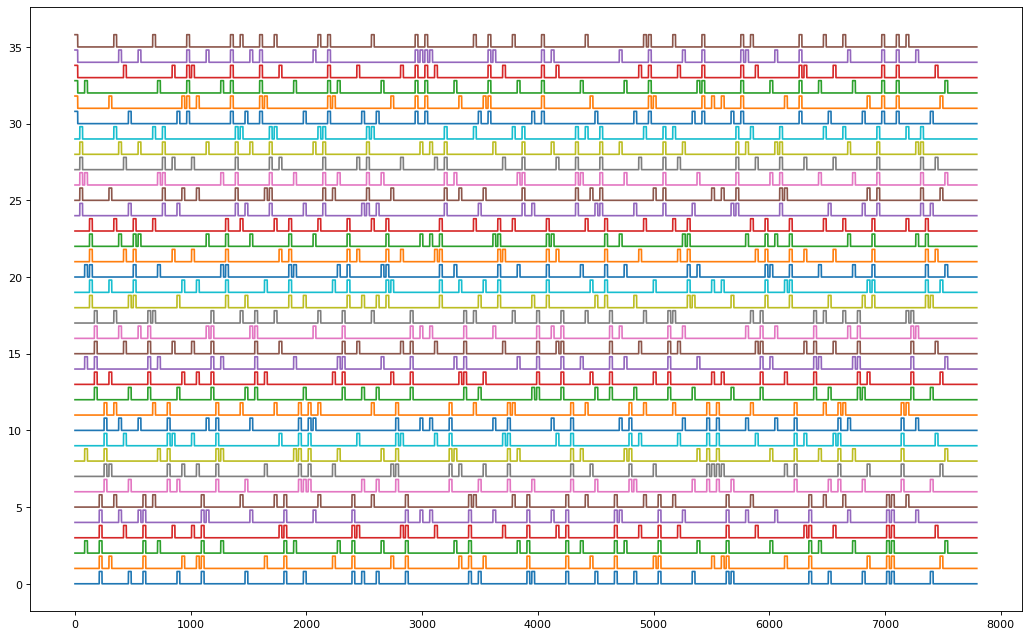

In [28]:
k = Y_train.shape[0] #length trials
m = Y_train.shape[1] #length samples
n = Y_train.shape[2] #length classes

fig=plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

for i in range(n):
    y = i + 0.8*Y_train[0, :, i]
    plt.plot(y)  

#plt.yticks([''])
plt.show()

Of course, instead of visualizing the timecourses as they are represented in `Y_train`, we can also reconstruct what the participant saw. Recall that the grid was a $6 \times 6$ grid. `Y_train` denotes for each cell in this grid whether it was "on" or "off". From the description of the dataset, we know that the flashes were of 100 ms duration with 75 ms inter-flash interval (i.e., a blank screen). This means that each 175 ms a new flash happened. 

Now, let's take the same trial as before (e.g. the first), and go through it in steps of 175 ms to plot the $6 \times 6$ grid for the first 20 flashes. Specifically, fill a grid of $6 \times 6$ with zeros, and put ones at those places that were flashed at that timepoint. You can then plot the grid as an image with `plt.imshow()`.

Let's also add in the attended cell. The variable `T_train` denotes the attended cell. Add this information to your grid by assigning a value of 2 to the attended target.

This visualization should show you the rows and columns as flashed during each *epoch*. Did your interpretation of the rows and columns from the codebook above match the reality? Also, can you make predictions about for which epochs a P300 response would be elicited and for which not?

Flash 1.0


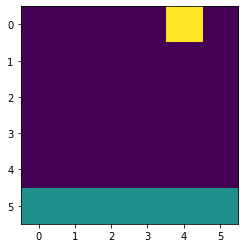

Flash 2.0


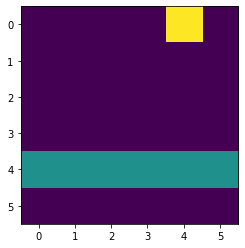

Flash 3.0


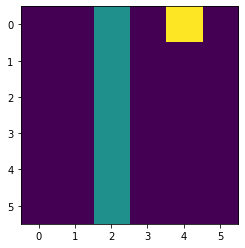

Flash 4.0


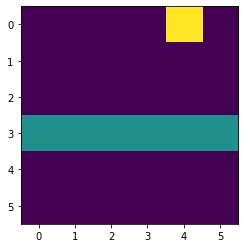

Flash 5.0


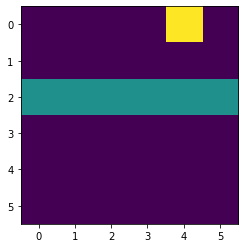

Flash 6.0


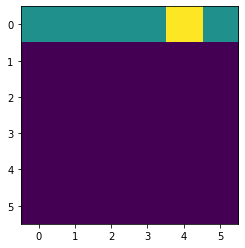

Flash 7.0


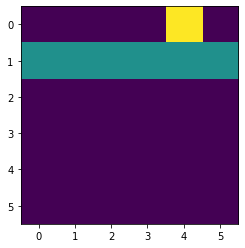

Flash 8.0


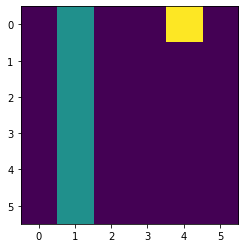

Flash 9.0


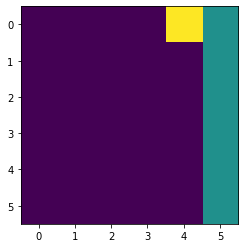

Flash 10.0


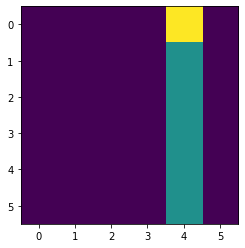

Flash 11.0


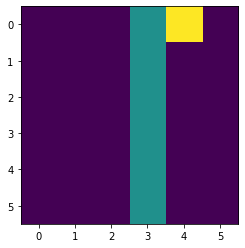

Flash 12.0


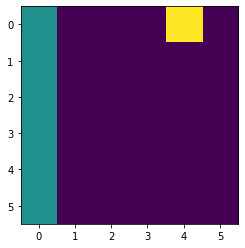

Flash 13.0


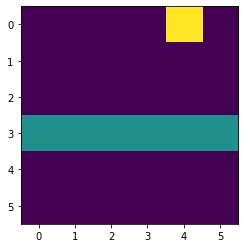

Flash 14.0


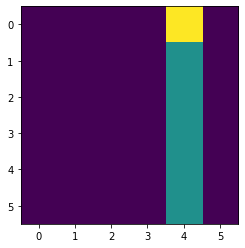

Flash 15.0


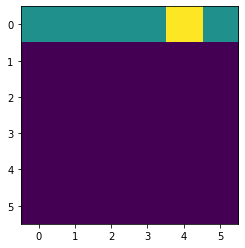

Flash 16.0


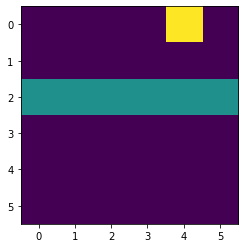

Flash 17.0


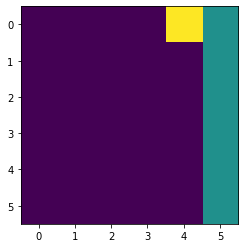

Flash 18.0


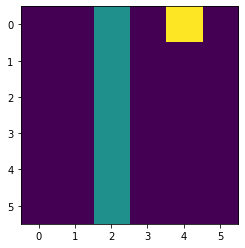

Flash 19.0


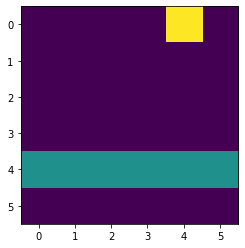

Flash 20.0


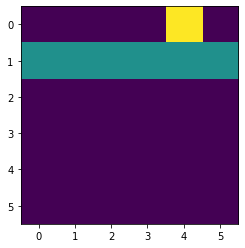

In [29]:
# 20 flashes * 175ms = 3500ms = 3.5 
# 3.5 * fs = 840 samples
# 840 / 20 = 42 --> 1 flash every 42 samples

m = Y_train.shape[1] #samples
n = Y_train.shape[2] #classes

for i in range(840):
    if i % 42 ==0:
        x = np.zeros((36))
        
        for j in range(n):
            if Y_train[0,i,j] == True:
                x[j]=1
            
            attendedLetter = T_train[0]
            x[attendedLetter] = 2
        
        x = np.reshape(x,(6,6))
        print("Flash", i/42 + 1)
        plt.imshow(x)
        plt.show()

### 1.2. The EEG data (0.25 points) <a class="anchor" id="eeg"></a>
So far, we discussed what `Y_train` and `T_train` mean -- the codebook and the targets. Let's inspect the EEG data. With the data, we have a list of the channel names `channels` so we know which channel was located where on the scalp, and we have the sample frequency `fs`, i.e., the number of measurements per second. 

Now, plot a trial (e.g., again the first) of channel Cz using `plt.plot()`.

Can you interpret the data visually, i.e., can you derive which cell the participant attended to? 


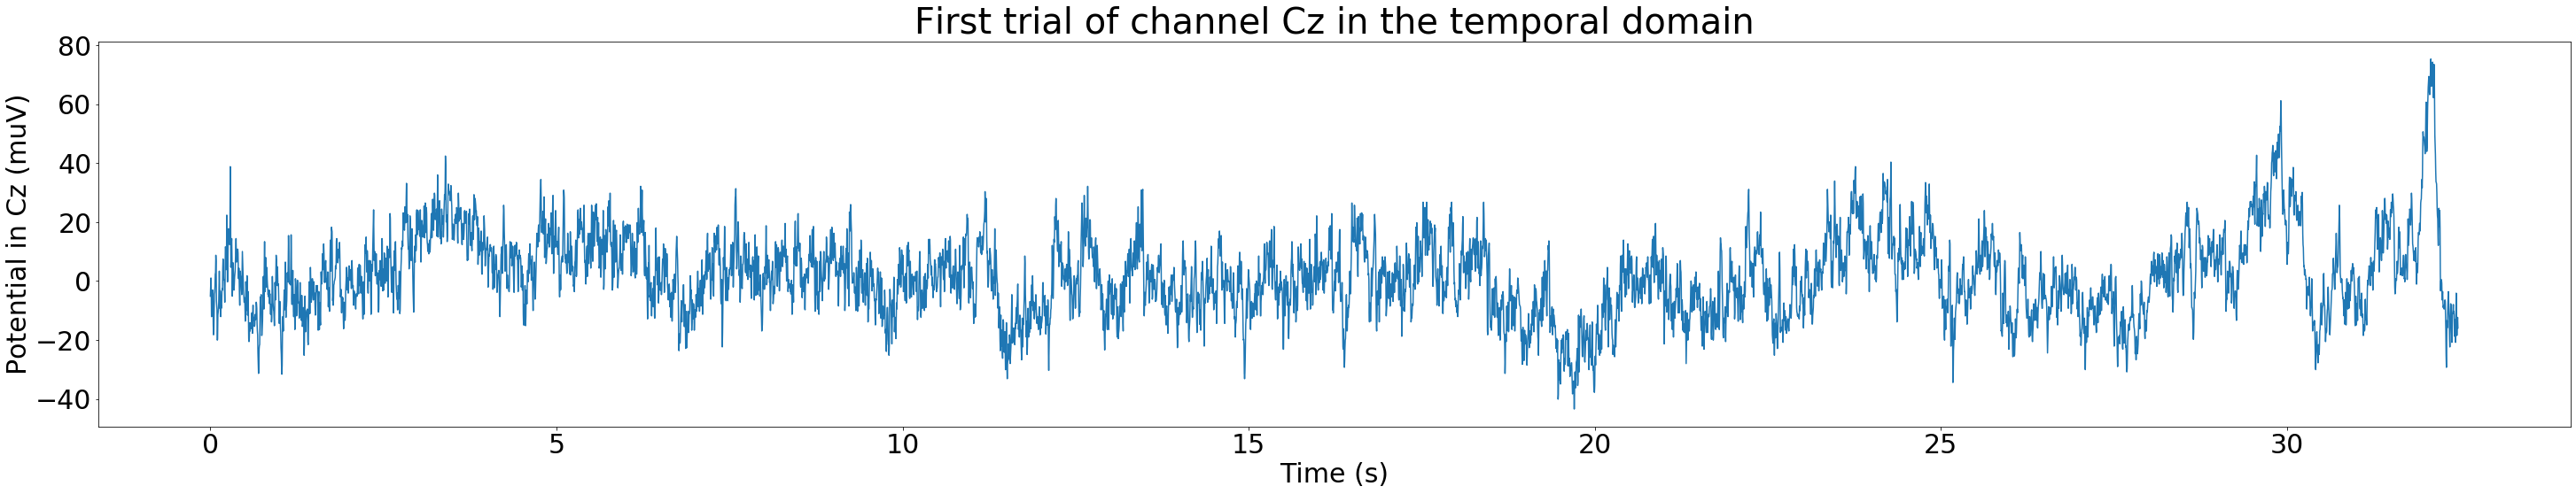

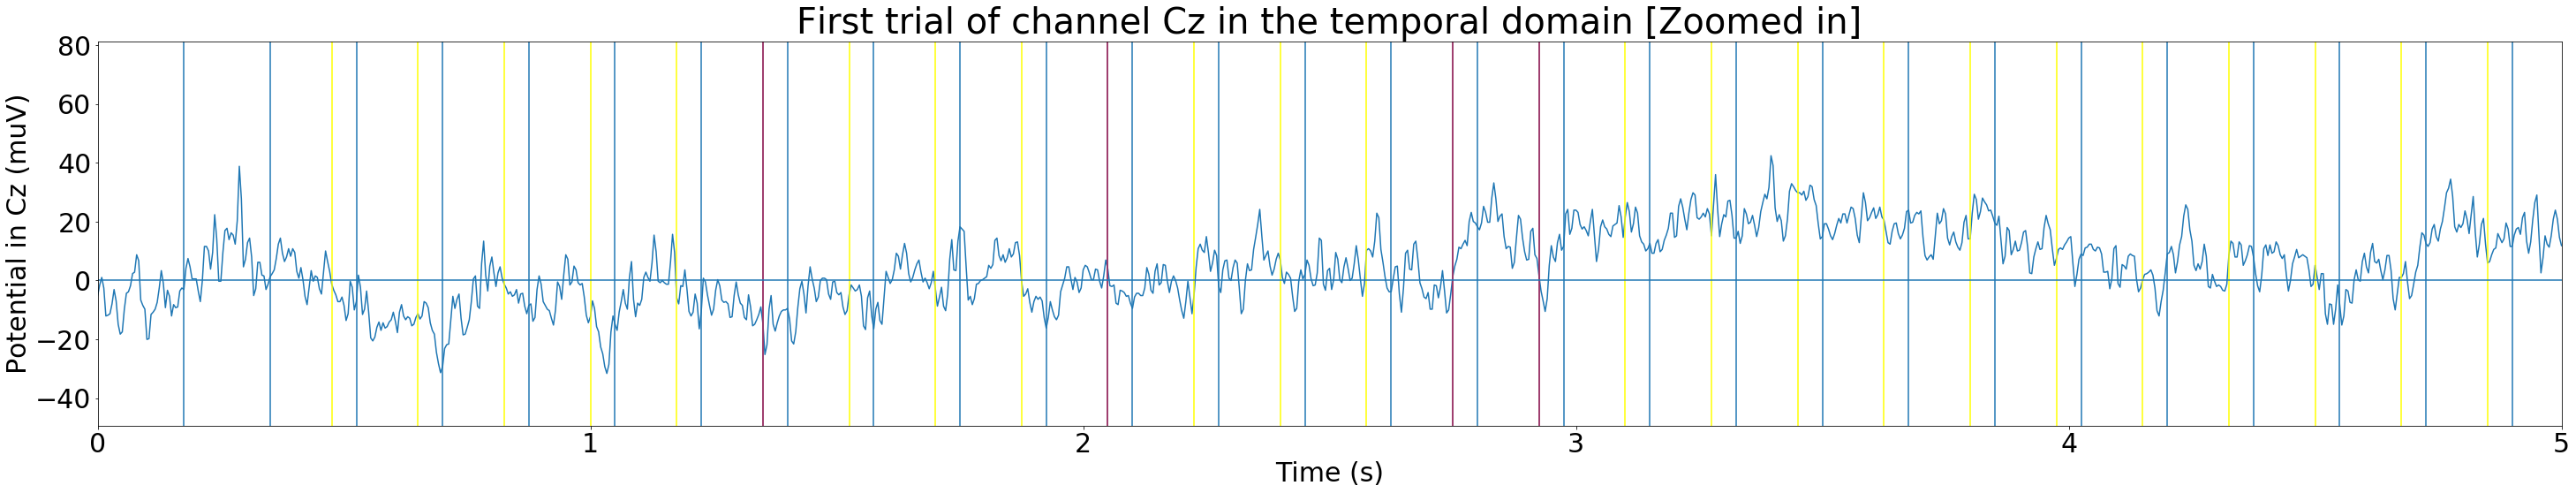

In [30]:
#CHECKCHECKCHECK

cz = channels.index('Cz')   

time = []
for i in range(m):
    time.append(i/fs)

fig, ax = plt.subplots(figsize=(50,8))
plt.plot(time, X_train[0,:,cz])
ax.tick_params(axis='both', which='major', labelsize=30)
plt.title("First trial of channel Cz in the temporal domain", fontsize=40)
plt.xlabel("Time (s)", fontsize=30)
plt.ylabel("Potential in Cz (muV)", fontsize=30)
plt.show()

flashes = []
p3 = []
t = 0
p = 0
for i in range(180):
    t += 0.175
    flashes.append(t)
    p = flashes[i] + .3
    p3.append(p)

fig, ax = plt.subplots(figsize=(50,8))
plt.plot(time, X_train[0,:,cz])
plt.xlim(0, 5)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.title("First trial of channel Cz in the temporal domain [Zoomed in]", fontsize=40)
plt.xlabel("Time (s)", fontsize=30)
plt.ylabel("Potential in Cz (muV)", fontsize=30)
for xc in flashes:
    plt.axvline(x=xc, label = 'Stimulus onset')
for xc in p3:
    plt.axvline(x=xc, c = 'yellow', label = 'P300')
    if xc == 1.35 or xc == 2.0500000000000003 or xc == 2.7499999999999996 or xc == 2.9249999999999994:
        plt.axvline(x=xc, c = 'purple', label = 'P300')
plt.axhline(y=0)
plt.show()

# Flash   -->   Sec     -->   P300
# 6             1.05          1.35 
# 10            1.75          2.05
# 14            2.45          2.75
# 15            2.625         2.925

QUESTION: Die lijntjes hoeven hier dus niet per se (?)

The above visualization shows us the data in the temporal domain. Let's transform this data to the frequency-domain and inspect which frequencies are present in the data.

Compute the frequency spectrum (i.e., power spectral density) of `X_train` using `periodogram()` from SciPy. Make sure the power spectrum is computed over the correct axis and with the correct samplefrequency. Then, plot the frequency spectrum of the same trial as above for channel Cz using `plt.plot()`. 

What do you observe? What can you say about the peaks in the lower spectrum, and what can you say about the peak at 60 Hz? Also, why do we see frequencies only up to 120 Hz when in fact our samplefrequency is higher?

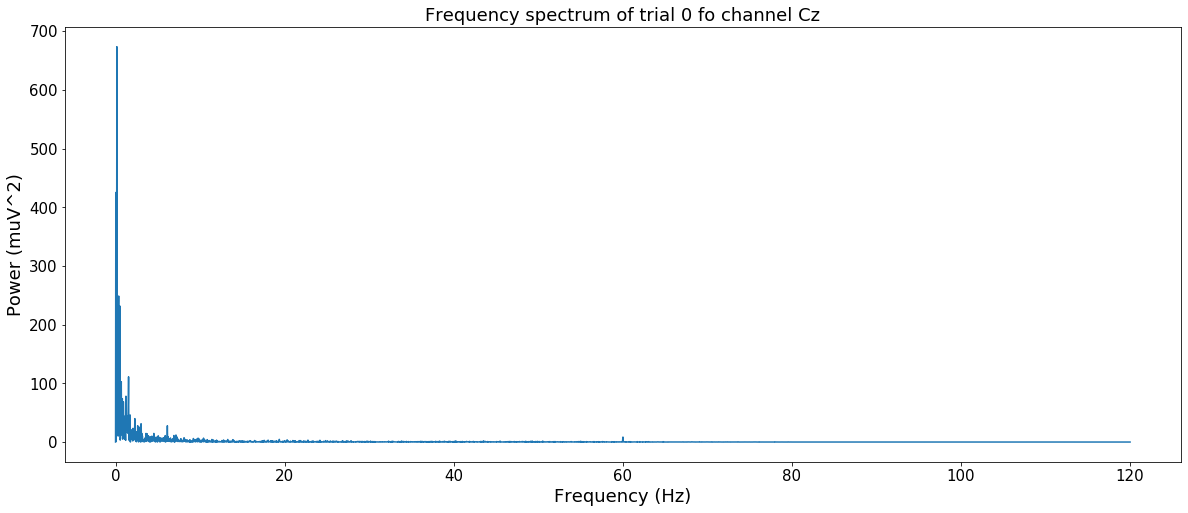

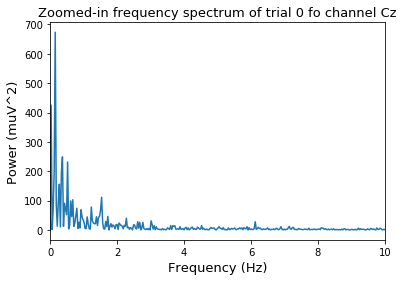

In [31]:
f, Pxx = periodogram(X_train[0,:,cz], fs)

fig, ax = plt.subplots(figsize=(20,8))
plt.plot(f, Pxx)
plt.title("Frequency spectrum of trial 0 fo channel Cz", fontsize = 18)
plt.xlabel("Frequency (Hz)", fontsize = 18)
plt.ylabel("Power (muV^2)", fontsize = 18, )
ax.tick_params(axis= 'both', which = 'major', labelsize=15)
plt.show()

plt.plot(f, Pxx)
plt.xlim(0,10)
plt.title("Zoomed-in frequency spectrum of trial 0 fo channel Cz", fontsize = 13)
plt.xlabel("Frequency (Hz)", fontsize = 13)
plt.ylabel("Power (muV^2)", fontsize = 13)
plt.show()

#CHECKCHECKCHECK correct axises?

We observe that the low frequencies have larger peaks in muV. This is common for unfiltered EEG signals, this behaviour is caused by the 1/f trend of brain signals. We will continue to filter out these high power low freuqnecies. At 60Hz we also see a peak, which is caused by line noise. The samplefrequency is the amount of samples per second and has in fact little to do with the shown frequency spectrum. After all, the frequencies shown there are from the brain, and show at which frequencies the power is high or low, and thus which are present. Usually the brain operates up to a range up to around 100Hz, so it makes sense that the frequencies higher than 120Hz are missing.

# 2. Preprocessing<a class="anchor" id="preproc"></a>
An important step in BCI is to clean the data from artefacts and noise-sources not relevant to the signal, and to enhance features in the signal to boost SNR. As we saw above, the data contains some frequencies we are not interested in, for instance the 60 Hz peak. Additionally, we know that ERPs tend to be slow.

### 2.1. Spectral filter (0.5 points) <a class="anchor" id="spectralfilter"></a>
Implement a low-pass filter with a cut-off frequency of 20 Hz and a high-pass filter with a cut-off at 0.1 Hz. To design the filter, use `butter()` from SciPy, and to apply the filter use `filtfilt` from SciPy. Note, there is plenty of choice in filter types and filter parameters to choose from. Here, use a 5th order filter in both cases. Note, apply the filters to both the training data as well as the validation data.

What does the low-pass filter do? What does the high-pass filter do? If you cannot answer these questions directly, look at what the data looks like before and after filtering.


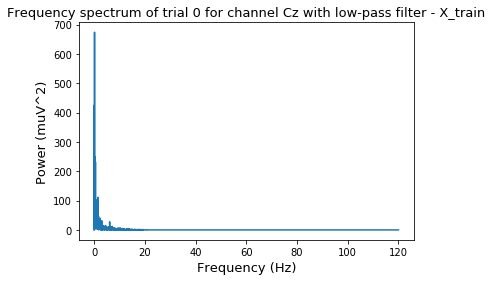

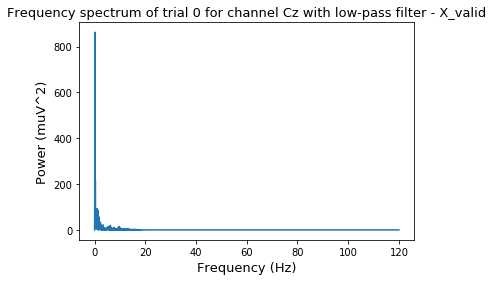

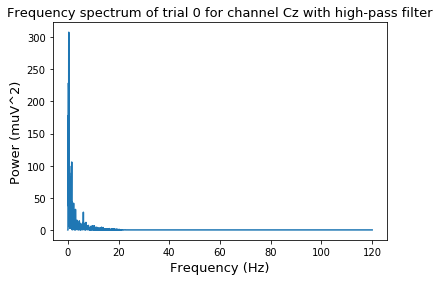

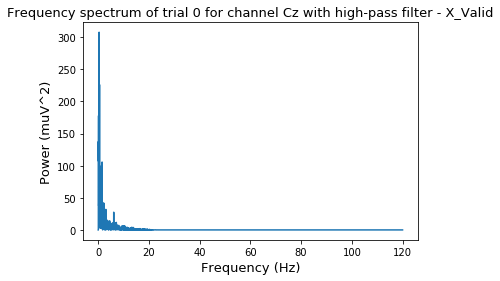

In [32]:
# variables
N = 5

fc = 20  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency

# low-pass with cut-off frequency of 20 Hz
b_low, a_low = butter(N, w, 'low')

# apply low pass filter to X_train and X_valid
X_train_low = filtfilt(b_low, a_low, X_train, axis = 1)
X_valid_low = filtfilt(b_low, a_low, X_valid, axis = 1)

# draw plot
f, Pxx = periodogram(X_train_low[0,:,cz], fs)
plt.plot(f,Pxx)
plt.title("Frequency spectrum of trial 0 for channel Cz with low-pass filter - X_train", fontsize=13)
plt.xlabel("Frequency (Hz)", fontsize=13)
plt.ylabel("Power (muV^2)", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.show()

f, Pxx = periodogram(X_valid_low[0,:,cz], fs)
plt.plot(f,Pxx)
plt.title("Frequency spectrum of trial 0 for channel Cz with low-pass filter - X_valid", fontsize=13)
plt.xlabel("Frequency (Hz)", fontsize=13)
plt.ylabel("Power (muV^2)", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.show()


# high-pass filter with a cut-off at 0.1 Hz
fc = 0.1          # cut-off frequency of the filter
w = fc / (fs / 2) # normalize the frequency
b_high, a_high = butter(N, w, 'high')


# apply high pass filter to X_train and X_valid
X_train_high = filtfilt(b_high, a_high, X_train_low, axis = 1)
X_valid_high = filtfilt(b_high, a_high, X_valid_low, axis = 1)

# draw plot
f, Pxx = periodogram(X_train_high[0,:,cz], fs)
plt.plot(f,Pxx)
plt.title("Frequency spectrum of trial 0 for channel Cz with high-pass filter", fontsize=13)
plt.xlabel("Frequency (Hz)", fontsize=13)
plt.ylabel("Power (muV^2)", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.show()

f, Pxx = periodogram(X_train_high[0,:,cz], fs)
plt.plot(f,Pxx)
plt.title("Frequency spectrum of trial 0 for channel Cz with high-pass filter - X_Valid", fontsize=13)
plt.xlabel("Frequency (Hz)", fontsize=13)
plt.ylabel("Power (muV^2)", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.show()

The lowpass filter lets through all frequencies below 20Hz and the highpass filter ensures that only signals from 0.1Hz and above can go through. This results in the total range of frequencies going from 0.1Hz up to 20Hz. 

### 2.2. Downsampling (0.5 points) <a class="anchor" id="downsampling"></a>
Another step is to downsample the data if needed. In many cases, EEG data is acquired at very high samplefrequencies even up to 2 KHz. Even though this adds temporal information, it might be redundant for classification since the actual phenomenon that we are interested in -- here ERPs -- typically do not happen at these high frequencies. Additionally, having a high samplefrequency means we have a lot of datapoints, each for which we will need to fit parameters later on. Building a simpler model is commonly better (e.g., to avoid overfitting) so having less *features* might be relevant.

Let's downsample the data to 40 Hz. The data was acquired at 240 Hz. We have already applied an anti-aliasing filter at the step above (i.e., 20 Hz low-pass), so we can safely *decimate* the data to 40 Hz. This is done by simply sampling evenly spaced samples from the data along the temporal axis. Do this for both the training and validation data, and for `X` as well as `Y`.

QUESTION: Willen ze nou wel of niet die Y?

(85, 7794, 64)
(85, 7794, 64)
(85, 1299, 64)


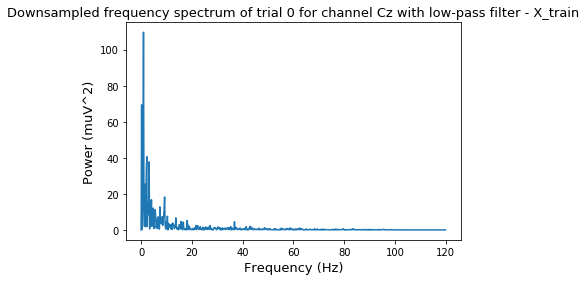

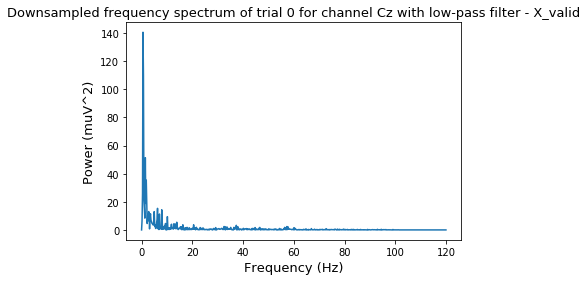

In [65]:
downsamplingFreq = 40

q = fs//downsamplingFreq
print(X_train.shape)
print(X_train_low.shape)

X_train_low_dec = decimate(X_train_low, q, axis = 1)
X_valid_low_dec = decimate(X_valid_low, q, axis = 1)
print(X_train_low_dec.shape)

f, Pxx = periodogram(X_train_low_dec[0,:,cz], fs)
plt.plot(f, Pxx)
plt.title("Downsampled frequency spectrum of trial 0 for channel Cz with low-pass filter - X_train", fontsize=13)
plt.xlabel("Frequency (Hz)", fontsize=13)
plt.ylabel("Power (muV^2)", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.show()

f, Pxx = periodogram(X_valid_low_dec[0,:,cz], fs)
plt.plot(f, Pxx)
plt.title("Downsampled frequency spectrum of trial 0 for channel Cz with low-pass filter - X_valid", fontsize=13)
plt.xlabel("Frequency (Hz)", fontsize=13)
plt.ylabel("Power (muV^2)", fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.show()

### 2.3. Trick for offline analysis<a class="anchor" id="trick"></a>
The cell below reorders `Y` such that the target is always at the end, i.e., `Y[:,:,-1]` denotes the target codebook. This is easy for data handling, as we do not need to look up the target codebook from `Y` with `T` anymore. This just saves bookkeeping. Remember, from this point onward, target/nontarget labels for *epochs* are identified by `Y[:,:,-1]`, and target labels for *single-trials* are always $n-1$ (minus one as we start counting from 0).

In [34]:
def put_target_last(Y, T):
    for i in range(T.size):
        Y[i, :, [-1, T[i]]] = Y[i, :, [T[i], -1]]
    return Y, T

# Put target at end
Y_train, T_train = put_target_last(Y_train, T_train)
Y_valid, T_valid = put_target_last(Y_valid, T_valid)


# 3. Data slicing<a class="anchor" id="slicing"></a>

The classification problem at hand is a two-class problem: target versus non-target or attended versus non-attended. Whenever the attended cell was flashed, a P300 is expected. Note, via this two-class problem, we will later on derive to which of 36 cells the participant was attending, which is a multi-class problem. 

We will use *block-processing*: the classification will be applied every time a flash happened (i.e., every *epoch*), because we want to know whether at that point in time this flash happened at the attended cell. If so, it should evoke a P300, if not no P300 is evoked. 

The first step then is to slice the trials into individual *epochs*. We know from the description that every row and column was flashed 15 times for 100 ms with 75 ms gaps, for a total of $12*15=180$ epochs each every 175 ms for each trial. 

Write a function `slice_data(X, Y, epoch_size)` that takes windows of data starting at these flashes. The size of the window is defined by `epoch_size`, and should cover the P300 response. Cut both training data and validation data, both `X` and `Y`, and call the sliced data `sX` and `sY` (i.e., the function outputs `sX` and `sY`). The dimensions should be $X_s \in \mathbb{R}^{k,p,c,m}$ and $Y_s \in \mathbb{R}^{k,p,n}$ with $k$ the number of trials, $p$ the number of epochs, $c$ the number of channels, $m$ the window size, and $n$ the number of classes.

### 3.1 Slicing to epochs (1.0 points) <a class="anchor" id="epochs"></a>

In [ ]:
QUESTION: Willen ze nou wel of niet die Y

In [72]:
# k = nr of trials 
# p = nr of epochs 
# c = nr of channels 
# m = window size 
# n = number of classes 

# sX[k, p, c, m]
# sY[k, p, n]

#epoch_size = 20          
timeofEpoch = 0.500    # a P300 response is visible from around 250 to 500ms after the flash and needs to be included
nrSamples = X_train.shape[1]
downsampledSamples = X_train_low_dec.shape[1]
startofEpochTime = 0.175
totalSamples = nrSamples / downsamplingFreq

epoch_size = int(downsamplingFreq * timeofEpoch)   # = 20
startofEpoch = int(startofEpochTime * downsamplingFreq) # = 7

def slice_data(X, Y, epoch_size):  
    sX=[]
    
    for i in np.arange(0, X.shape[1], startofEpoch):
        sX.append(X[:, i:i+epoch_size, :])
    return np.array(sX[:180]) #, sY


sX_train = slice_data(X_train_low_dec, Y_train, epoch_size)
print(sX_train.shape)


(180, 85, 20, 64)


In [64]:
print(fs)

240


In [54]:
# Print some properties
n_trials, n_epochs, n_channels, n_samples = sX_train.shape
n_trials, n_epochs, n_classes = sY_train.shape

print("Training")
print("sX", sX_train.shape, sX_train.dtype)
print("sY", sY_train.shape, sY_train.dtype)

print("Validation")
print("sX", sX_valid.shape, sX_valid.dtype)
print("sY", sY_valid.shape, sY_valid.dtype) 


ValueError: not enough values to unpack (expected 4, got 3)

### 3.2. Temporal response (0.5 points)<a class="anchor" id="temporal"></a>
Now that we sliced the data, the fun can start. A first thing to check is that we sliced the data correctly and that we actually recorded a nice P300 response. We can do so by computing the actual ERP in the training data. For this we do not care about different trials, so we reshape `sX` and `sY` to $X_s \in \mathbb{R}^{k*p,c,m}$ and $Y_s \in \mathbb{R}^{k*p,n}$. Also, note that we had put the target/non-target information at the back of `Y`, so we can take target/non-target label information by taking `sY[:,:,-1]`.

With this information, compute the mean over all target and for non-target epochs. Then, plot the ERPs for the channels Fpz, Cz, Pz, and O1 in separate figures while overlaying the target and non-target ERP. Specifically, use `plt.subplots` to create 4 figures, and plot the two ERPs with `plt.plot()`. Add a legend so you know which one is which.

Also, print how many targets and how many non-targets are in the training data. Why do we have more non-targets?

What can you observe from the visualization? Which channel do you think contains the most information? Do you see differences between frontal, central, parietal or occipital electrodes? What explains these differences?

Note, we now only plotted the averages. In most cases, you would also want to see the variance. Do you have an idea as to why?

In [ ]:
# code here.

### 3.3. Spatial response (0.5 points) <a class="anchor" id="spatial"></a>
Apart from a temporal profile, an ERP always comes with a spatial profile too. This profile might be time dependent. Let's visualize the spatial distribution at two timepoints. Use the `topoplot` function with the electrode layout in `assignment1_channels.txt` and plot the spatial distribution of the target ERP at 175 ms and at 400 ms. 

What do you observe? Can you explain the two topographies?

In [ ]:
# code here.

# 4. Decoding the neural code<a class="anchor" id="decoding"></a>
The above ERP looks beautiful, but as you can read from your printed information, it is the average of many repetitions. Instead, the BCI has to work out whether a single epoch is a target or a non-target. Let's see how we can do this.

### 4.1. Classifier calibration (0.5 points)<a class="anchor" id="calibration"></a>

Write a function `calibrate(sX, sY)` that takes in the training data and uses the full timeseries of Cz to classify an epoch. For classification we first use a *post-processing* step that normalizes the data. For this we use the `StandardScaler()` from sklearn. In the second step we use the `LinearDiscriminantAnalysis()` classifier from sklearn. For this classifier, set the solver to "eigen" and shrinkage to "auto". Those two steps can be conveniently packed together in a "pipeline" by making use of sklearn's `make_pipeline()`. The function should output the pipeline. 

To calibrate a pipeline we just call the `fit()` method on the pipeline with the inputs (`sX`) and targets (`sY`). In sklearn, these have to be a 2D matrix (examples by features) and a 1D (examples) respectively. Since we classify epochs, we again forget about the trial information and reshape `sX` to $X_s \in \mathbb{R}^{k*p,m}$ -- note we took only Cz (feature selection) --, and $Y_s \in \mathbb{R}^{k*p}$ -- note we take the last entry again which contains the target.

Use the function to calibrate your LDA classifier on the training data.

In this setting -- using Cz only -- we fit a temporal filter. In a similar vein, when we instead specify one timepoint and keep all channels, we fit a spatial filter. Ultimately, one can fit a spatiotemporal filter by keeping both spatial as well as temporal information. To do so, one can flatten the two dimensions, i.e., vectorize the features. For now, we stick with a temporal filter.

In [ ]:
# code here.

### 4.2. Epoch prediction (0.5 points) <a class="anchor" id="ep"></a>
Given the trained classifier, we can start to classify new epochs. Write a function `predict_epochs(pipeline, sX)` that receives the calibrated pipeline and data `sX`. It should perform the same feature selection process that the training procedure followed (i.e., vectorizing trials and epochs and selecting Cz). 

Then, to apply the classifier, normally one would use the `predict()` function of the pipeline. Instead, here we use the `decision_function()` method to get raw scores. 

Next, convert these raw scores to probabilities by applying a *sigmoid*, i.e. $f(x)=\frac{1}{1+e^{-x}}$. This now represents the probability of the input being a target or not. Then, extend this vector with the probability of not being a target (i.e., $1-p$). Finally, reshape this matrix back to the original shape so that the output of this function becomes $P \in \mathbb{R}^{2,k,p}$, denoting the probability of each trial's epoch to be one of the classes.

Use this function to predict the probabilities for both training as well as validation data. Call these probabilities `sP_train` and `sP_valid`, i.e., the probabilities for sliced training and validation data.

In [ ]:
# code here.

### 4.3. Epoch classification (0.5 points) <a class="anchor" id="ec"></a>
To classify an epoch, we simply maximize its probability of being a target or non-target. Write a function `classify_epochs(sP)` that receives the probabilities and outputs per trial and epoch whether it was a target or non-target, i.e., it outputs `sYh`.

Apply the function to the predicted probabilities of the training and validation data. With these, you can compute a training and validation performance of classifying P300 responses (targets versus non-targets), by comparing them with the accompanying ground truth labels in `sY`. Compute the classification accuracies for both training and validation data. Additionally, plot confusion matrices using the `confusionmatrix()` function.

Did the classifier perform well?

In [ ]:
# code here.

### 4.4. Trial prediction (0.5 points) <a class="anchor" id="tp"></a>
The goal of the P300 speller is not to comunicate target versus non-target information, but instead to communicate to which cell the participant is attending, i.e., which symbol the participant wants to select. For this we use the epoch predictions, i.e., the probabilities of an epoch within a trial being a target or not. 

Write a function `predict_trials(pipeline, sX, sY)` that first uses `predict_epochs()` to get the probabilities `sP` for `sX`. Then, since we have multiple cells to work with, we will aggregate the information per cell given the information in the codebook `sY`. Make a variable `P` with dimensions $P \in \mathbb{R}^{n, k, p}$, that takes probability $p$ if there was a flash for the $n$th cell in the $k$th trial and the $p$th epoch, and otherwise $1-p$. 

Apply this function to both training as well as validation data. Basically, this function makes the conversion from the two-class target versus non-target problem to the multi-class symbols problem.

In [ ]:
# code here.

### 4.5. Trial classification (0.5 points) <a class="anchor" id="tc"></a>
Now we are finally ready to classify trials. The `P` variables contain all information we need. Basically, they denote how likely the $n$th class is at the $k$th trial and $p$th epoch. We will accumulate the information that we have over multiple epochs to form a decision. 

Write a function `classify_trials(P)` that takes the probabilities, sums the evidence over epochs for individual symbols and trials, and emits the decision by maximizing this evidence over symbols. This function outputs `Yh` which is a vector with $k$ predictions, one for each trial.

Predict the labels for both the training as well as the testing data. From these we can directly compute the trial-level classification accuracy, since we know that the correct target was always at the back of `Y` (i.e., the ground truth label is $n-1$). Compute the performance for both training and validation data.

Did the classifier perform well?

In [ ]:
# code here.

### 4.6. Decoding curves (0.5 points) <a class="anchor" id="dc"></a>
Apart from classification accuracy, an important aspect of BCI is how long classification takes. For example, which classifier would you prefer, one that is 99% correct but takes 10 minutes per selection, or one that is 80% correct and takes 10 seconds per selection? The answer to this question might depend on what we use the BCI for, but to be able to answer the question, we need to compute *decoding curves*. Decoding curves show the classification accuracy as a function of the amount of data used for classification. In general, of course, more data would result in higher classification. 

Since our `P` estimates are already expressed as $P \in \mathbb{R}^{n, k, p}$, we can show the effect of integration length on classification performance. Write a loop over epochs ($p$) and perform the classification on all epochs until the current epoch (i.e., evidence is only accumulated until that epoch). Store these decoding accuracies in an array and plot the decoding curves for both training and validation set. In these plots, add a line that denotes chance level.

What do you observe? Does more data mean better classification? Did we already reach an optimal decoding accuracy, or can we still improve by adding more data?

In [ ]:
# code here.

### 4.7. Inspecting the classifier (0.5 points)<a class="anchor" id="classifier"></a>
Many BCI research is focused around engineering a working system. By inspecting the system, we can maybe find ways to improve it, but it might also inform us about the information the BCI is using and provide us with valuable information for e.g. cognitive neuroscience. 

The LDA classifier we used here learned parameters for individual timepoints of Cz. This means the classifier learned a temporal filter. We can visualize this filter and loosely inspect what it finds important and what not. Remember that such a filter does not tell us at what timepoint the discriminable information is, as some timepoints might be used only for noise cancellation (and by definition noise has no discriminable information).

Plot the parameters learned by LDA. These are stored in `pipeline[1].coef_`.

Do you see any patterns?

In [ ]:
# code here.

# 5. Extension: Canonical Correlation Analysis<a class="anchor" id="extension"></a>

A next step to improve classification would be to use more and more channels by adding them in the feature selection process. Instead, we can predefine a spatial filter based on the knowledge that we have. With CCA we can utilize the fact that we are dealing with ERPs. Let's see how this works.

### 5.1 The CCA (1.3 points)<a class="anchor" id="cca"></a>
CCA is defined as follows:
$$W_x, W_y = {\arg\max}_{W_x, W_y}\frac{W_x^\top X \cdot Y^\top W_y}{W_x\top X X^\top W_x \cdot W_y^\top Y Y^\top W_y}$$
Specifically, CCA optimizes $W_x$ and $W_y$ such that the correlation between the projections $W_x^\top X$ and $W_y^\top Y$ is maximized. This is very convenient for use with ERPs. Let $X$ be the raw single-trials, and $Y$ be the averaged data (i.e., ERPs), then $W_x$ and $W_y$ become spatial filters that maximize the correlation between spatially filter EEG data and its ERP. 

Write a function `fit_cca(sX, sY)` that learns the spatial filters $W_x$ and $W_y$. First, vectorize the inputs, i.e., reshape `sX` to $X_s \in \mathbb{R}^{k*p,c,m}$ and `sY` to $Y_s \in \mathbb{R}^{k*p}$ -- note we take the last entry again which contains the target. Then, extract the target epochs and store them in a variable called `eeg`. From this variable, compute the erp by taking the average over epochs and store this in `erp`. Now, use `np.tile()` to repeat `erp` to the same shape as `eeg`. Both `eeg` and `erp` should have the same dimensions now. Permute and reshape both matrices to 2D matrices of shape $k*p \times c$. Finally, use `CCA()` from sklearn with n_components=1 and use `fit()` with `eeg` and `erp` as inputs to perform the CCA. The optimized $W_x$ and $W_y$ can be found in `cca.x_weights_` and `cca.y_weights`.

Baically what we are doing here, is to match each single-trial with its ERP. Since we only have one ERP, this seems a bit odd, but essentially the CCA will optimize two spatial filters for us, so that each single-trial is made to resemble the ERP. The CCA does so by optimizing a spatial filter that boosts those channels that contain the signal, while optimally utilizing the other channels to reduce noise. Note, that the CCA optimizes a correlation. Multiplying both $W_x$ and $W_y$ with -1, i.e., changing its polarity, will not change the correlation. Hence, the CCA has freedom in choosing the polarity.

Use the function to fit the spatial filters using the training data.

In [ ]:
# code here

Next we want to apply the spatial filter $W_x$ to both the training and validation data to optimally combine the information in all channels. Write a function `apply_cca(sX, Wx)` that takes the multichannel data `sX`, and uses `Wx` to perform a weighted sum over channels. The output can be stored in `sfX`. 

Note, there is a very simple mathematical operation that performs $X_{sf}=W_x^\top X_{s}$. Additionally, you either write a for loop over trials/epochs, or you temporarily reshape the data to a 2D matrix to perform this operation.

Apply the function to both training and validation data to obtain `sfX_train` and `sfX_valid`.

In [ ]:
# code here.

### 5.2. Classifier calibration (0.2 points)<a class="anchor" id="calibration2"></a>
As in the previous part, we need to calibrate a classifier. However, now we use the spatially filtered data, so we do not need to perform channel selection. Use your previously defined calibration function `calibrate()` but this time using the spatially filtered training data.

In [ ]:
# code here.

### 5.3. Epoch prediction (0.2 points)<a class="anchor" id="ep2"></a>
Also in the epoch prediction, we can reuse the previously defined function, but this time inputting the spatially filtered data. Use your previously defined function `predict_epochs()` to predict the epoch probabilities using the spatially filtered data.

In [ ]:
# code here.

### 5.4. Epoch classification (0.2 points)<a class="anchor" id="ec2"></a>
Also in the epoch classification, we can reuse the previously defined function. Use your previously defined function `classify_epochs()` to classify the epoch probabilities that were defined using the spatially filtered data.

Can you already see an improvement?

In [ ]:
# code here.

### 5.5. Trial prediction (0.2 points)<a class="anchor" id="tp2"></a>
Let's now use the previously defined `predict_trials()` function to convert to probabilities over different symbols. Make sure you use the spatially filtered data for both training and validation set. 

In [ ]:
# code here.

### 5.6. Trial classification (0.2 points)<a class="anchor" id="tc2"></a>
In a similar fashion, reuse `classify_trials()` to use the probabilities and accumulate evidence over epochs to form a decision on trial-level. Do this for both training and validation set and compute the classification accuracies.

Did the classification improve?

In [ ]:
# code here.

### 5.7. Decoding curves (0.2 points)<a class="anchor" id="dc2"></a>
Also for the CCA-based classifier, we can estimate decoding curves. Also here you can reuse your code from before. Plot the decoding curves for both training and validation set, and plot a line that denotes chance level. 

Do you see an improvement over the one-channel classifier?

In [ ]:
# code here.

### 5.8. Inspecting the classifier (0.5 points)<a class="anchor" id="classifier2"></a>
Like before we can inspect the classifier to obtain insight in what the classifier learned. First, plot the temporal filter like previously. Second, use the `topoplot()` function with the `assignment1_channels.txt` layout file to plot the spatial filters $W_x$ and $W_y$. 

Can you interpret the temporal filter? Can you explain what the spatial filter shows? Could you argue why $W_x$ and $W_y$ are slightly different, and with that, why we use $W_x$ as spatial filter and not $W_y$?

In [ ]:
# code here.